# Investigating well position effect: Scenario 4 (MAPK, LPAR1, Batch 6)
**Author:** Jessica Ewald <br>

Here we train on three plates and test on the fourth, all from the same batch. 

These results are for only one example: train on "2023-12-15_B4A3R1_P1T2", "2023-12-18_B4A3R1_P1T3", "2023-12-15_B4A3R1_P1T1", test on "2023-12-18_B4A3R1_P1T4". These plates are from batch 4. This scenario is most similar to our real analysis strategy. 

This version of scenario 4 compares different controls (MAPK and LPAR1) because the ALK WT and VAR both suffered from low cell viability. The protein channel here is therefore an even easier task. 

In [1]:
# Imports
import pathlib
import polars as pl
import pandas as pd
import numpy as np
from scipy import stats
import os
import seaborn as sns
import matplotlib.pyplot as plt

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

import warnings
warnings.filterwarnings("ignore")

DEBUG:jupyter_black:config: {'line_length': 79, 'target_versions': {<TargetVersion.PY310: 10>}}


<IPython.core.display.Javascript object>

In [2]:
result_dir = pathlib.Path(
    f"/dgx1nas1/storage/data/jess/varchamp/sc_data/classification_results/Rep_Ctrls_scen4_B6_MAPK_LPAR1_30Apr2024"
)
batch = "Rep_Ctrls_scen4"
feature_sets = ["non_protein", "protein", "brightfield"]

In [3]:
# Read in all F1 score and plot
comparisons = [
    "REF_control_f1score",
    "VAR_control_f1score",
    "NULL_control_f1score",
    "f1score",
]
comp_dict = {
    "REF_control_f1score": "REF_REF",
    "VAR_control_f1score": "VAR_VAR",
    "NULL_control_f1score": "NULL",
    "f1score": "REF_VAR",
}

f1_score = pl.DataFrame()
for fs in feature_sets:
    for comp in comparisons:

        df = pl.read_csv(
            f"{result_dir}/Rep_Ctrls_scen4_{fs}_{comp}_normalized_feature_selected.csv"
        )

        if "Reference_Well" in df.columns:
            df = df.rename(
                {"Reference_Well": "Well_One", "Variant_Well": "Well_Two"}
            )

        df = df.melt(id_vars=["Well_One", "Well_Two"]).with_columns(
            pl.lit(fs).alias("Feature_Set"),
            pl.lit(comp_dict[comp]).alias("Comparison"),
            pl.lit(batch).alias("Batch"),
        )
        f1_score = pl.concat([f1_score, df], how="vertical")

In [5]:
# Most separable REF-REF pair
f1_score.filter(
    (pl.col("Comparison") == "REF_REF") & (pl.col("variable") == "F1_Score")
).sort(pl.col("value"), descending=True).select(["Well_One", "Well_Two"])[0]

Well_One,Well_Two
str,str
"""K20""","""P03"""


In [5]:
# Most separable VAR-VAR pair
f1_score.filter(
    (pl.col("Comparison") == "VAR_VAR") & (pl.col("variable") == "F1_Score")
).sort(pl.col("value"), descending=True).select(["Well_One", "Well_Two"])[0]

Well_One,Well_Two
str,str
"""E18""","""F17"""


In [6]:
# Most separable REF-VAR pair
f1_score.filter(
    (pl.col("Comparison") == "REF_VAR") & (pl.col("variable") == "F1_Score")
).sort(pl.col("value"), descending=True).select(["Well_One", "Well_Two"])[0]

Well_One,Well_Two
str,str
"""F11""","""M08"""


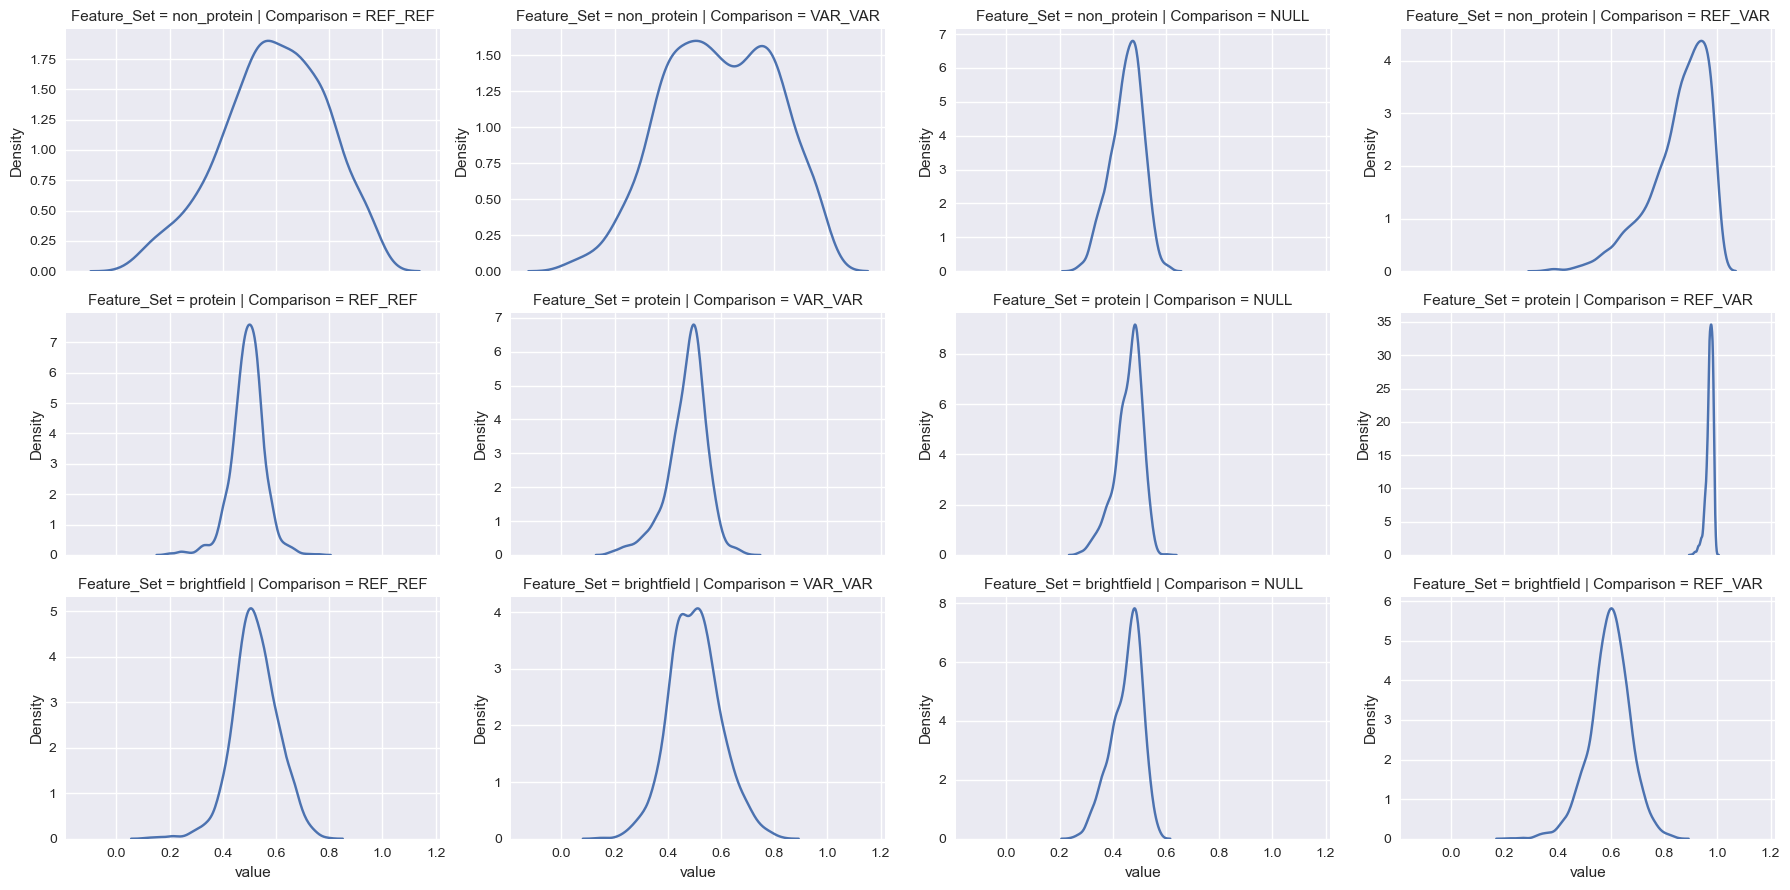

In [4]:
# plot F1 scores, faceted by Feature Set and Comparison
plt.style.use("seaborn")

g = sns.FacetGrid(
    f1_score.filter(pl.col("variable") == "F1_Score").to_pandas(),
    row="Feature_Set",
    col="Comparison",
    aspect=1.5,
    sharey=False,
)
g.map(sns.kdeplot, "value")

plt.show()

# VAR = MAPK, REF = LPAR1

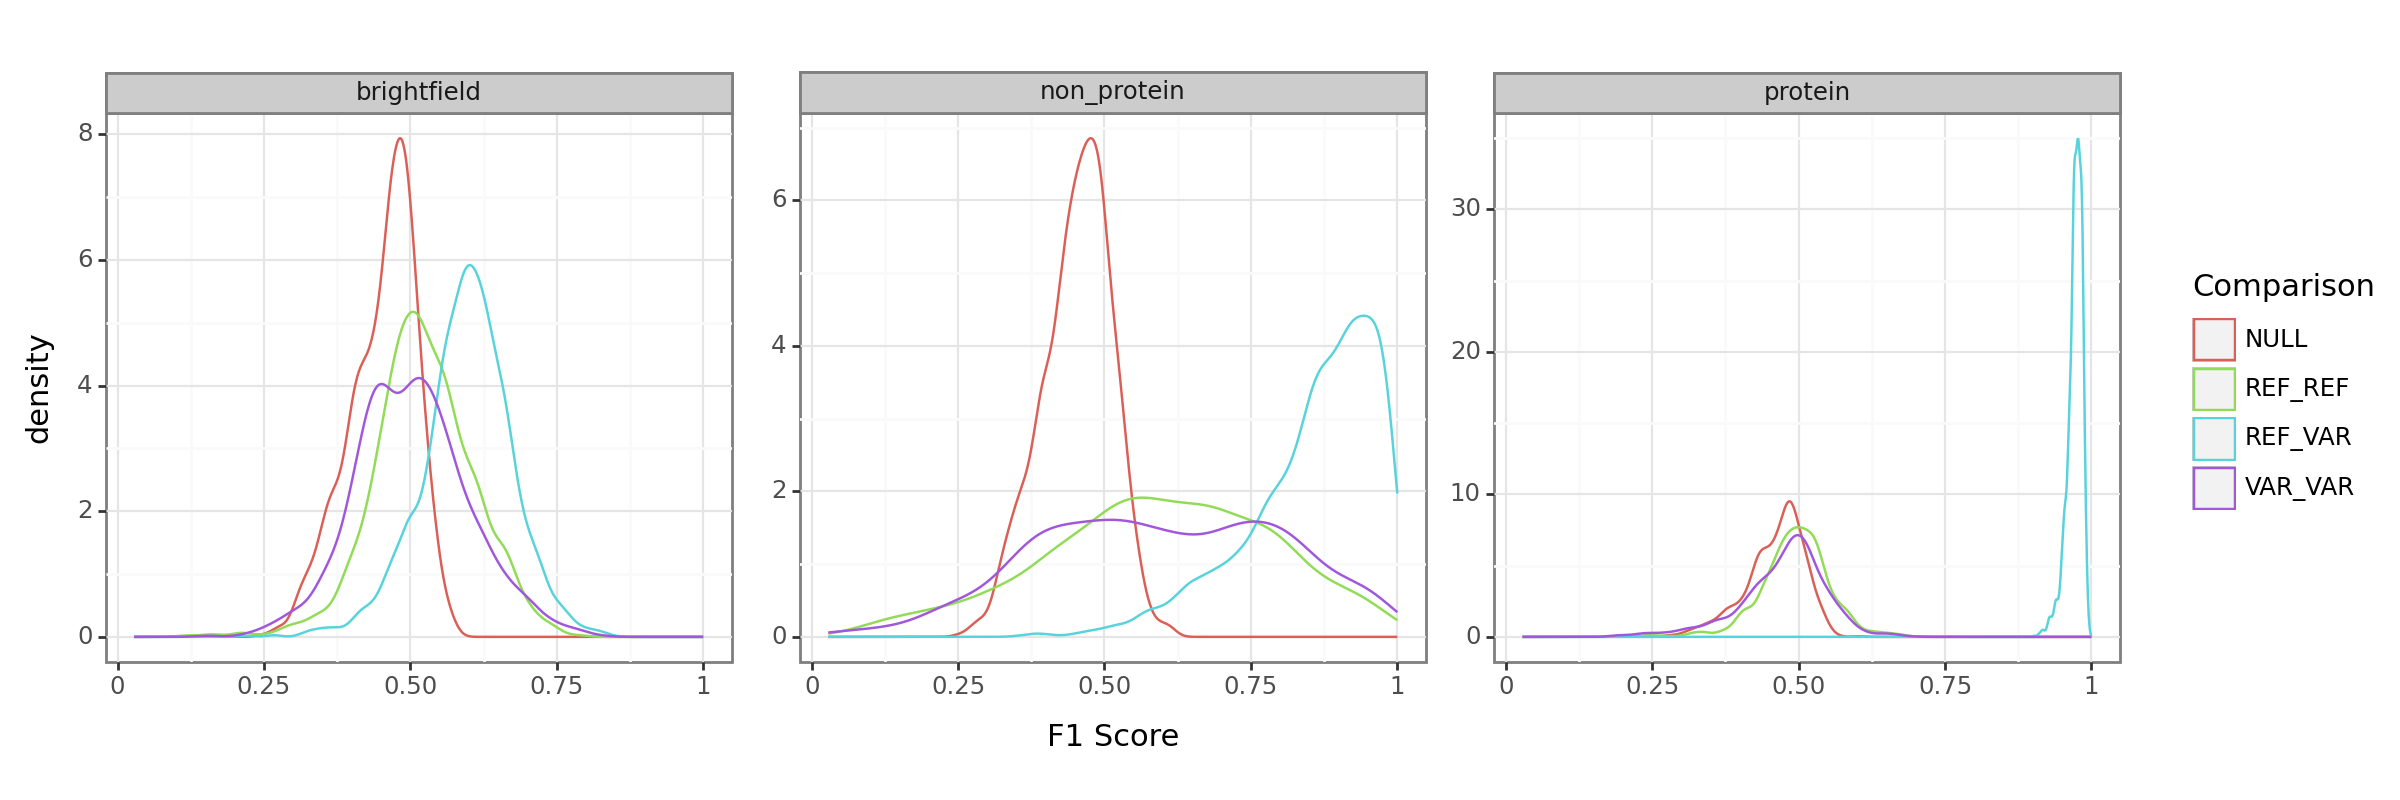

In [6]:
# try histograms with ggplot
import plotnine as pn
from plotnine import ggplot, aes, geom_density, theme_bw, xlab, facet_wrap, theme

pn.options.figure_size = (12,4)

plot1 = (ggplot(f1_score.filter(pl.col("variable") == "F1_Score").to_pandas()) 
+ aes(x = "value", color="Comparison")
+ facet_wrap("Feature_Set", scales='free_y')
+ geom_density()
+ theme_bw()
+ xlab("F1 Score"))

print(plot1)

In [4]:
# Read in all variable feature importance scores

comparisons = [
    "REF_control_feat_importance",
    "VAR_control_feat_importance",
    "NULL_control_feat_importance",
    "feat_importance",
]
comp_dict = {
    "REF_control_feat_importance": "REF_REF",
    "VAR_control_feat_importance": "VAR_VAR",
    "NULL_control_feat_importance": "NULL",
    "feat_importance": "REF_VAR",
}

feat_imp = pl.DataFrame()
for fs in feature_sets:
    for comp in comparisons:

        df = pl.read_csv(
            f"{result_dir}/Rep_Ctrls_scen4_{fs}_{comp}_normalized_feature_selected.csv"
        )

        if "Reference_Well" in df.columns:
            df = df.rename(
                {"Reference_Well": "Well_One", "Variant_Well": "Well_Two"}
            )

        df = df.melt(id_vars=["Well_One", "Well_Two"]).with_columns(
            pl.lit(fs).alias("Feature_Set"),
            pl.lit(comp_dict[comp]).alias("Comparison"),
            pl.lit(batch).alias("Batch"),
        )
        feat_imp = pl.concat([feat_imp, df], how="vertical")

In [5]:
# Add unique identifier
feat_imp = feat_imp.with_columns(
    pl.concat_str(
        [
            pl.col("Well_One"),
            pl.col("Well_Two"),
            pl.col("Feature_Set"),
            pl.col("Comparison"),
        ],
        separator="_",
    ).alias("ClassifierID")
)

# Add rank of feature within each classifier
feat_imp = feat_imp.with_columns(
    pl.col("value")
    .rank(descending=True)
    .over("ClassifierID")
    .alias("FIP_rank")
)

In [6]:
# summarize ranks
imp_summary = feat_imp.group_by(["variable", "Feature_Set", "Comparison"]).agg(
    pl.col("FIP_rank").mean().alias("mean_VIP"),
    pl.col("value").mean().alias("mean_FIP")
)

plot_var = "mean_FIP"

protein_summary = imp_summary.filter(pl.col("Feature_Set") == "protein")
nonprotein_summary = imp_summary.filter(pl.col("Feature_Set") == "non_protein")
bright_summary = imp_summary.filter(pl.col("Feature_Set") == "brightfield")

prot_summary = imp_summary.filter(pl.col("Feature_Set") == "protein").pivot(
    index="variable", columns="Comparison", values=plot_var
)
nonprot_summary = imp_summary.filter(
    pl.col("Feature_Set") == "non_protein"
).pivot(index="variable", columns="Comparison", values=plot_var)

brightfield_summary = imp_summary.filter(
    pl.col("Feature_Set") == "brightfield"
).pivot(index="variable", columns="Comparison", values=plot_var)

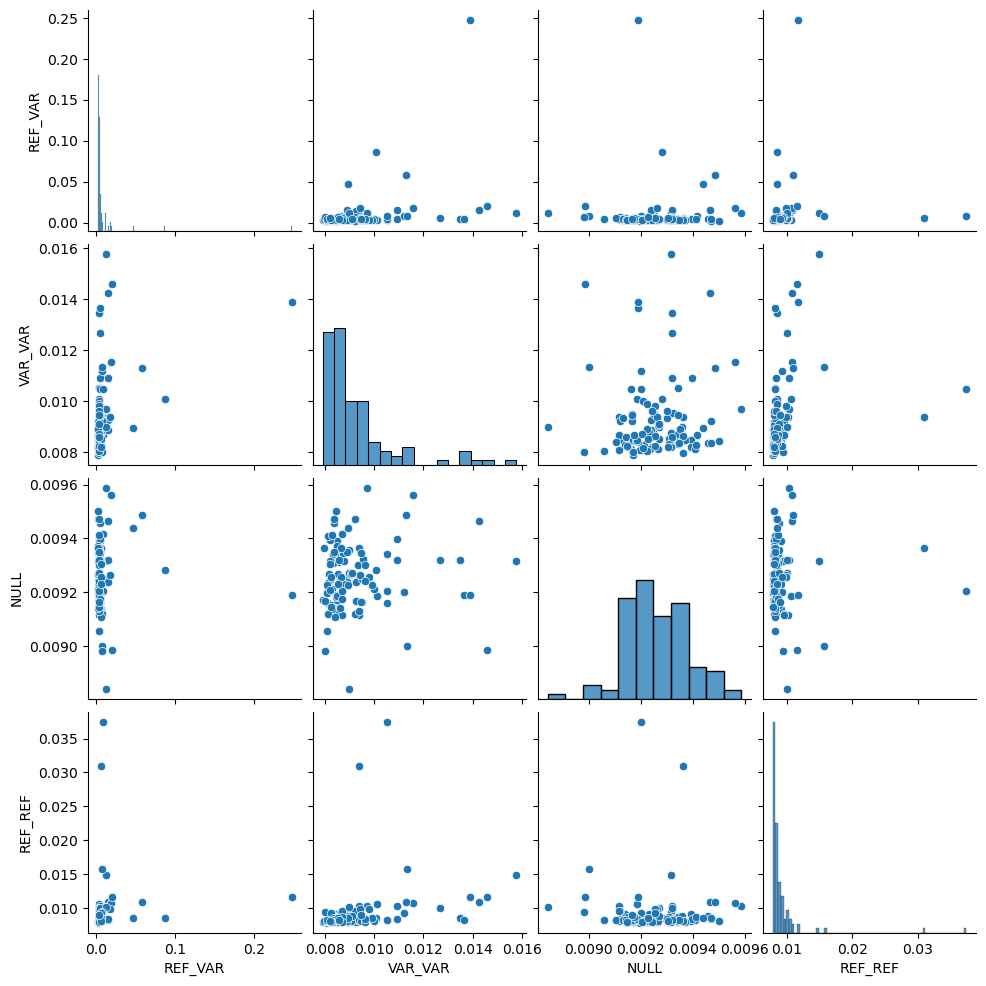

In [7]:
sns.pairplot(prot_summary.to_pandas())

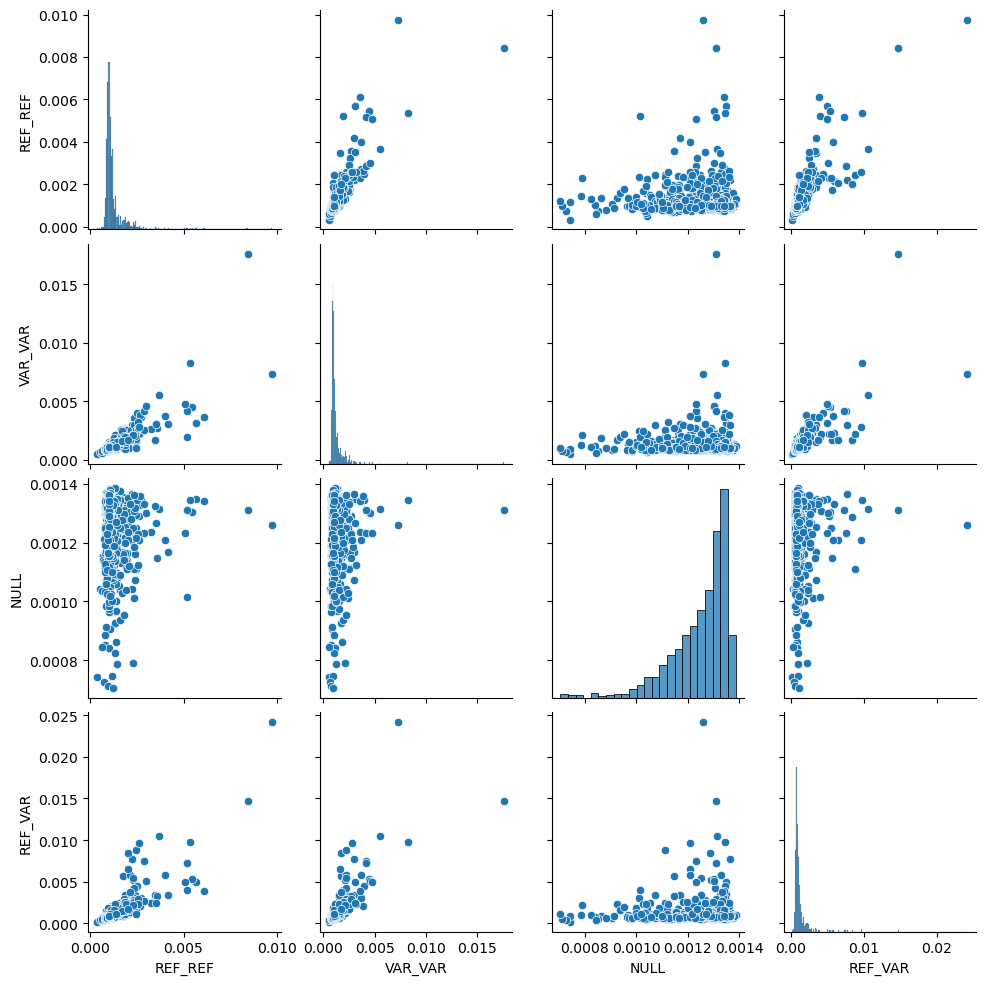

In [8]:
sns.pairplot(nonprot_summary.to_pandas())

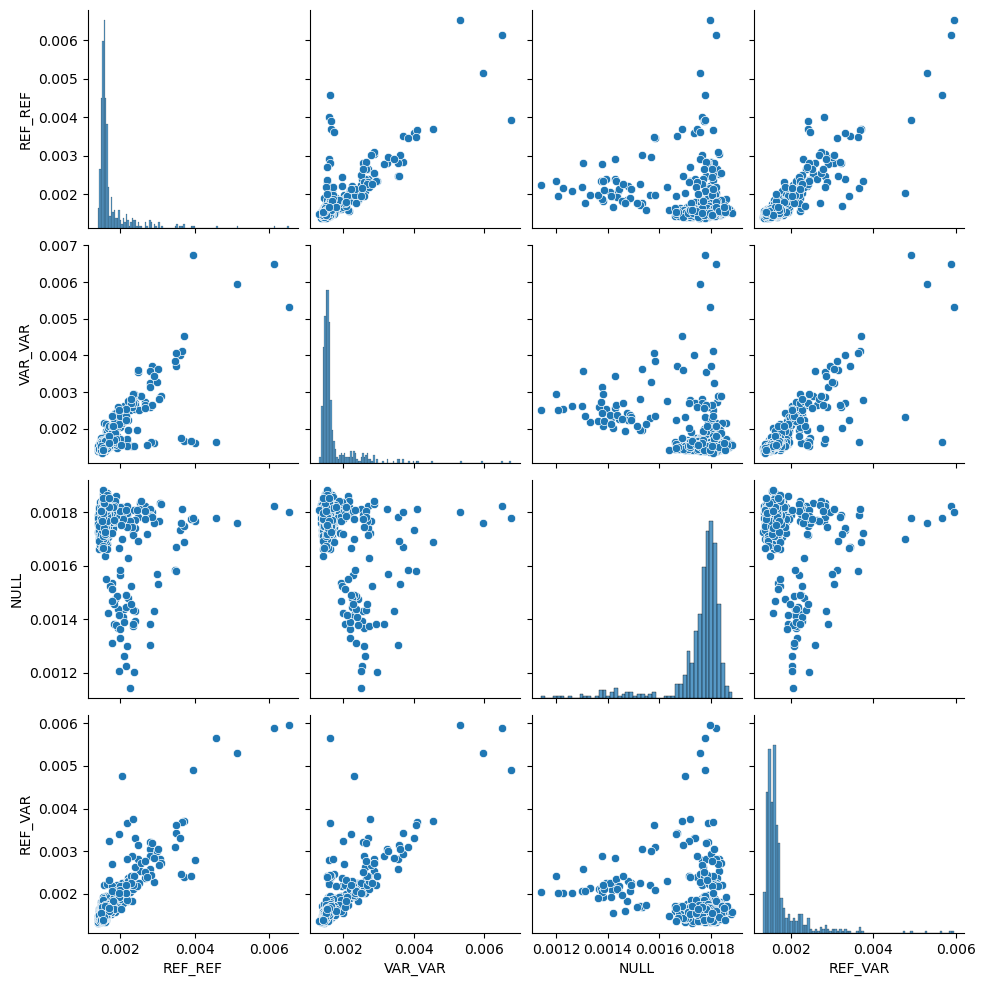

In [9]:
sns.pairplot(brightfield_summary.to_pandas())

Next, analyze these scores to see if there is any spatial pattern across the plate.

In [12]:
f1_score = f1_score.filter(pl.col("variable") == "F1_Score")

# Convert well name into row and column coordinates
f1_score = f1_score.with_columns(
    pl.col("Well_One").str.slice(0, 1).alias("Well_One_Letter"),
    pl.col("Well_One").str.slice(1).cast(pl.Int64).alias("Well_One_Col"),
    pl.col("Well_Two").str.slice(0, 1).alias("Well_Two_Letter"),
    pl.col("Well_Two").str.slice(1).cast(pl.Int64).alias("Well_Two_Col"),
)

letter_dict = {
    "A": 1,
    "B": 2,
    "C": 3,
    "D": 4,
    "E": 5,
    "F": 6,
    "G": 7,
    "H": 8,
    "I": 9,
    "J": 10,
    "K": 11,
    "L": 12,
    "M": 13,
    "N": 14,
    "O": 15,
    "P": 16,
}

f1_score = f1_score.with_columns(
    pl.Series(
        name="Well_One_Row",
        values=[
            letter_dict[val]
            for val in f1_score.select(pl.col("Well_One_Letter")).to_series()
        ],
    ),
    pl.Series(
        name="Well_Two_Row",
        values=[
            letter_dict[val]
            for val in f1_score.select(pl.col("Well_Two_Letter")).to_series()
        ],
    ),
)

In [14]:
# Compute physical distance between pairs of wells
import math

phys_dist = []
for row in f1_score.rows(named=True):
    phys_dist.append(
        math.dist(
            [row["Well_One_Row"], row["Well_One_Col"]],
            [row["Well_Two_Row"], row["Well_Two_Col"]],
        )
    )

In [15]:
dists = f1_score.with_columns(
    pl.Series(name="Phys_dist", values=phys_dist),
    pl.concat_str(
        [pl.col("Well_One"), pl.col("Well_Two")], separator="-"
    ).alias("Well_Pair"),
)

In [16]:
f1_filt = dists.filter(
    (
        (pl.col("Comparison").is_in(["REF_REF", "VAR_VAR"]))
        & (pl.col("Phys_dist") < 3)
    )
    | ((pl.col("Comparison") == "REF_VAR") & (pl.col("Phys_dist") > 10))
)

In [17]:
# Compute correlation between cosine similarity and physical distance
dist_cor = dists.group_by(["Comparison", "Feature_Set"]).agg(
    pl.corr("value", "Phys_dist", method="pearson").alias("Cor_F1_Dist")
)
dist_cor.sort(
    pl.col(
        ["Feature_Set", "Comparison"],
    )
)

Comparison,Feature_Set,Cor_F1_Dist
str,str,f64
"""NULL""","""non_protein""",-0.052315
"""REF_REF""","""non_protein""",0.167741
"""REF_VAR""","""non_protein""",0.134581
"""VAR_VAR""","""non_protein""",0.126044
"""NULL""","""protein""",-0.073104
"""REF_REF""","""protein""",0.106138
"""REF_VAR""","""protein""",-0.176602
"""VAR_VAR""","""protein""",0.02113


In [18]:
# Check p-values for protein manually
cor_ref_ref = stats.pearsonr(
    dists.filter(
        (pl.col("Feature_Set") == "protein")
        & (pl.col("Comparison") == "REF_REF")
    )
    .select("value")
    .to_series(),
    dists.filter(
        (pl.col("Feature_Set") == "protein")
        & (pl.col("Comparison") == "REF_REF")
    )
    .select("Phys_dist")
    .to_series(),
)

cor_var_var = stats.pearsonr(
    dists.filter(
        (pl.col("Feature_Set") == "protein")
        & (pl.col("Comparison") == "VAR_VAR")
    )
    .select("value")
    .to_series(),
    dists.filter(
        (pl.col("Feature_Set") == "protein")
        & (pl.col("Comparison") == "VAR_VAR")
    )
    .select("Phys_dist")
    .to_series(),
)

cor_ref_var = stats.pearsonr(
    dists.filter(
        (pl.col("Feature_Set") == "protein")
        & (pl.col("Comparison") == "REF_VAR")
    )
    .select("value")
    .to_series(),
    dists.filter(
        (pl.col("Feature_Set") == "protein")
        & (pl.col("Comparison") == "REF_VAR")
    )
    .select("Phys_dist")
    .to_series(),
)

cor_null = stats.pearsonr(
    dists.filter(
        (pl.col("Feature_Set") == "protein") & (pl.col("Comparison") == "NULL")
    )
    .select("value")
    .to_series(),
    dists.filter(
        (pl.col("Feature_Set") == "protein") & (pl.col("Comparison") == "NULL")
    )
    .select("Phys_dist")
    .to_series(),
)

print(cor_ref_ref)
print(cor_var_var)
print(cor_ref_var)
print(cor_null)

PearsonRResult(statistic=0.10613780397035444, pvalue=0.0003558219549038148)
PearsonRResult(statistic=0.02113030508270553, pvalue=0.4783439349163883)
PearsonRResult(statistic=-0.1766020419733803, pvalue=1.3480459404248354e-17)
PearsonRResult(statistic=-0.07310350670170894, pvalue=0.014057234836580649)


In [19]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=15, cmap=cmap, **kwargs)

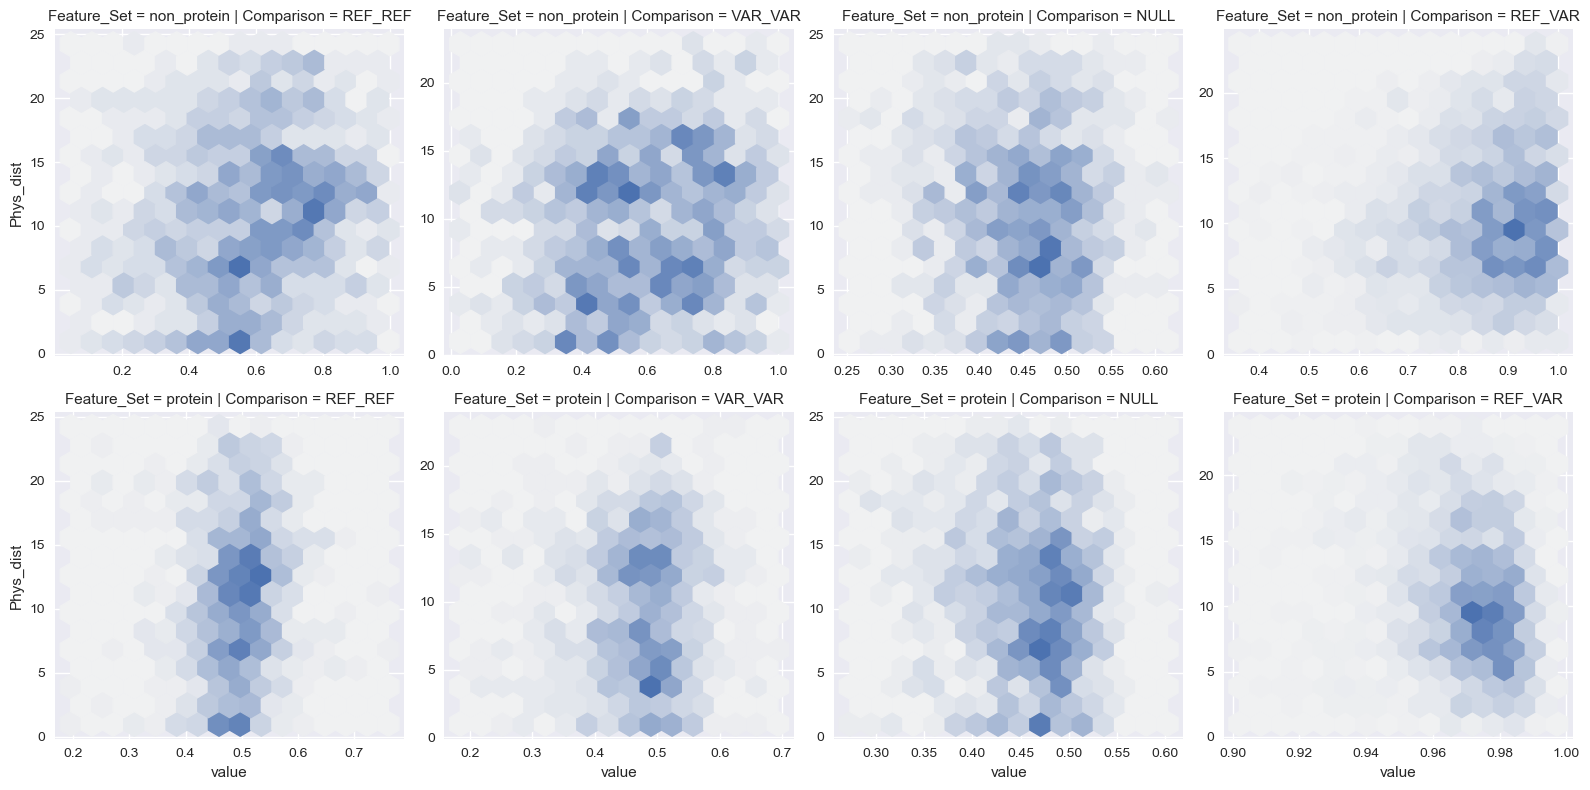

In [20]:
g = sns.FacetGrid(
    dists.to_pandas(),
    row="Feature_Set",
    col="Comparison",
    aspect=1,
    height=4,
    sharex=False,
    sharey=False,
)
g = g.map(hexbin, "value", "Phys_dist")
plt.show()

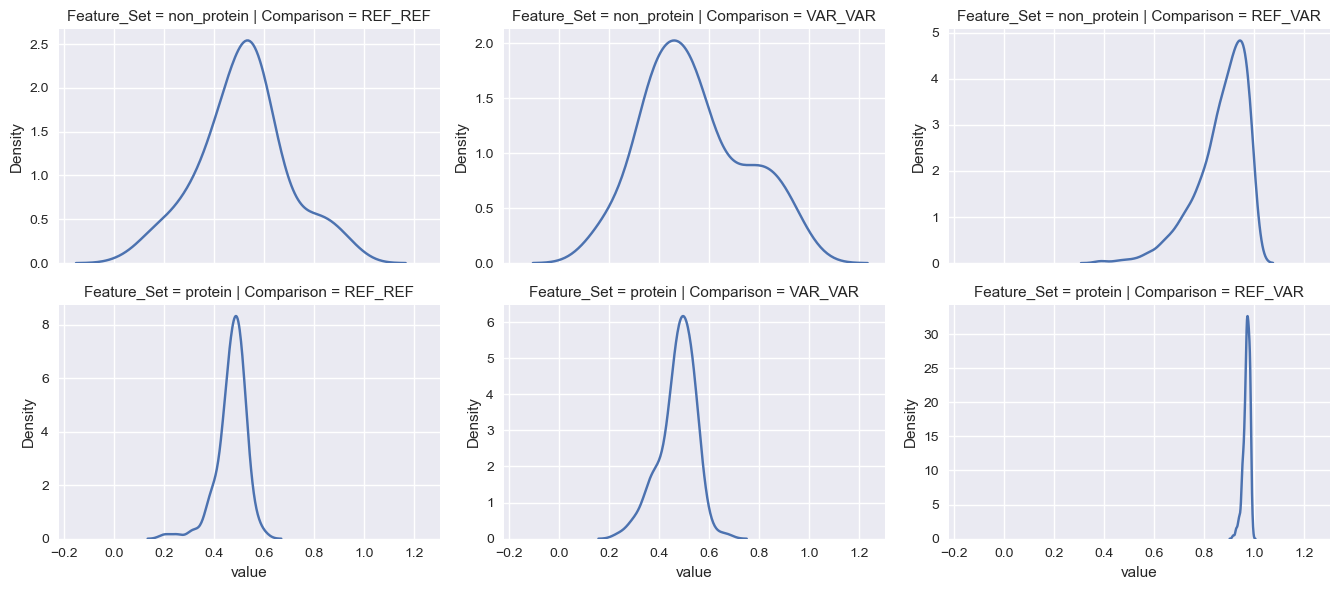

In [21]:
# Remake F1 score facet plot but after filtering by distance
plt.style.use("seaborn")

g = sns.FacetGrid(
    f1_filt.filter(pl.col("variable") == "F1_Score").to_pandas(),
    row="Feature_Set",
    col="Comparison",
    aspect=1.5,
    sharey=False,
)
g.map(sns.kdeplot, "value")

plt.show()

In [22]:
# Next, perform FIP comparison again, but after filtering to look at only classifiers with high performance (>0.9)
good_classifiers = f1_score.filter((pl.col("variable") == "F1_Score") & (pl.col("value") > 0.9))
good_classifiers = good_classifiers.with_columns(
    pl.concat_str(
        [
            pl.col("Well_One"),
            pl.col("Well_Two"),
            pl.col("Feature_Set"),
            pl.col("Comparison"),
        ],
        separator="_",
    ).alias("ClassifierID"))

keep_classifiers = good_classifiers.select(pl.col("ClassifierID")).unique().to_series().to_list()
good_feat_imp = feat_imp.filter(pl.col("ClassifierID").is_in(keep_classifiers))

# summarize ranks
imp_summary = good_feat_imp.group_by(["variable", "Feature_Set", "Comparison"]).agg(
    pl.col("FIP_rank").mean().alias("mean_VIP")
)
prot_summary = imp_summary.filter(pl.col("Feature_Set") == "protein").pivot(
    index="variable", columns="Comparison", values="mean_VIP"
)
nonprot_summary = imp_summary.filter(
    pl.col("Feature_Set") == "non_protein"
).pivot(index="variable", columns="Comparison", values="mean_VIP")

brightfield_summary = imp_summary.filter(
    pl.col("Feature_Set") == "brightfield"
).pivot(index="variable", columns="Comparison", values="mean_VIP")


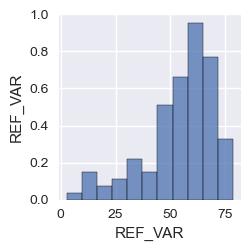

In [23]:
sns.pairplot(prot_summary.to_pandas())

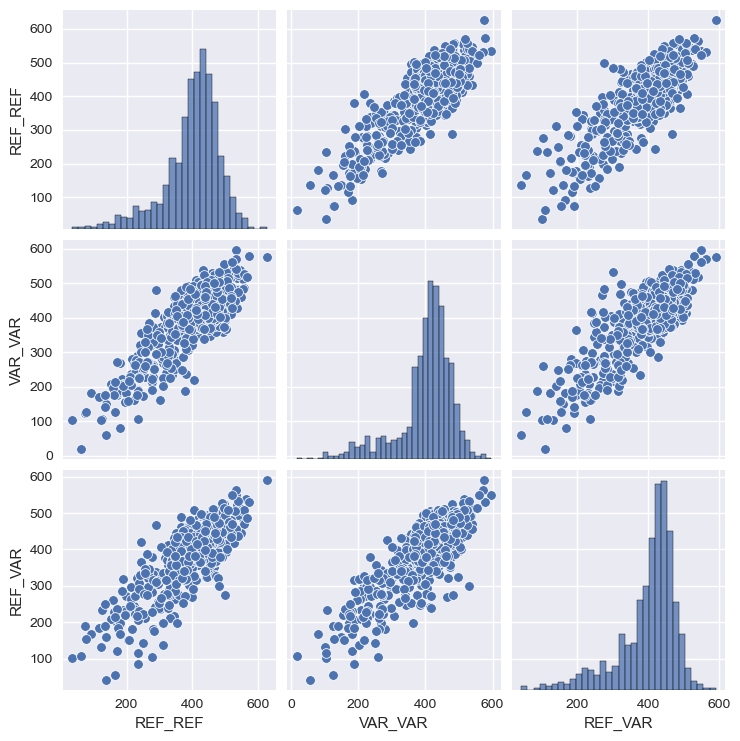

In [24]:
sns.pairplot(nonprot_summary.to_pandas())

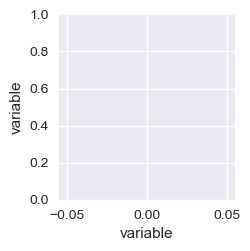

In [25]:
sns.pairplot(brightfield_summary.to_pandas())